In [11]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from aerobot.io import RESULTS_PATH, load_results_dict, DATA_PATH
from aerobot.plot import plot_configure_mpl, ANNOTATION_BASED_FEATURE_TYPES, PRETTY_NAMES, plot_order_feature_types, plot_phylo_cv
import os
from typing import Dict, List
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plot_configure_mpl()

LEVELS = ['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'] # Define the taxonomic levels. Kingdom is ommitted.

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Load in the results of each training run. 
nonlinear_results = dict() # Results of Nonlinear classifier. 
logistic_results = dict() # Results of LogisticRegression-based classifier. 

# Only load results for a minimal list of feature types.
for feature_type in ['KO', 'embedding.geneset.oxygen', 'embedding.genome', 'chemical', 'aa_1mer', 'aa_3mer']:
    filename = f'train_nonlinear_{feature_type}_ternary.json'
    nonlinear_results[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, filename))
    filename = f'train_logistic_{feature_type}_ternary.json'
    logistic_results[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, filename))

In [13]:
randrel_results = {'random relative':load_results_dict(os.path.join(RESULTS_PATH, f'phylo_cv_nonlinear_{feature_type}_ternary.json'))}
taxonomy_coverage_df = pd.read_csv(os.path.join(DATA_PATH, 'earth_microbiome', 'taxonomy_coverage.csv'))

## Figure 1

In [15]:
def plot_figure_1a(grid:GridSpec=None, fig:plt.Figure=None):
    '''Just a placeholder, the diagram describing annotation-ful versus annotation-free pipelines for
    predicting metabolism will go here.'''
    ax = fig.add_subplot(grid)
    ax.set_axis_off()
    #ax.set_visible(False)

In [28]:
def plot_figure_1b(randrel_results:Dict, taxonomy_coverage_df:pd.DataFrame, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plot illustrating the predictive power of phylogeny. Will include a line indicating the performance of the RandomRelative classifier
    at each taxonomic level, as well as a line indicating taxonomy label coverage at each level.'''
    ax = fig.add_subplot(grid)

    handles, labels = plot_phylo_cv(randrel_results, ax=ax) # Function returns the handles and labels for the legend.

    # Add another axis to the plot for showing taxonomy coverage. 
    right_ax = ax.twinx()
    right_ax.set_ylabel('percent coverage')
    n = len(taxonomy_coverage_df) # Number of habitats. 
    # for i, level in enumerate(LEVELS):
    #     ax.scatter(np.array([i] * n), taxonomy_coverage_df[level].values, linewidth=0.5, facecolors=colors, s=sizes)# , edgecolors=edgecolors)

    x_vals = [i + 1 for i in range(len(LEVELS))]
    y_vals = [taxonomy_coverage_df[level].mean() for level in LEVELS[::-1]]
    handles += right_ax.plot(x_vals, y_vals, c='tab:gray', lw=1)
    labels.append('coverage')
    right_ax.scatter(x_vals, y_vals, c='tab:gray', s=20)

    ax.legend(handles, labels, fontsize=7, columnspacing=0.3, handletextpad=0.3, loc='lower left')

In [29]:
def plot_figure_1c(nonlinear_results:Dict, logistic_results:Dict, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plot comparing Nonlinear and Logistic ternary classifier performance on the holdout set.'''

    ax = fig.add_subplot(grid)
    feature_types = plot_order_feature_types(set(nonlinear_results.keys()))

    def _format_barplot_axes(ax:plt.Axes):
        random_baseline = 0.33 # Expected performance for random classifier on task. 
        # Label bins with the feature name. 
        ax.set_xticks(np.arange(0, len(feature_types), 1), [PRETTY_NAMES[f] for f in feature_types], rotation=45, ha='right')

        # Set up left y-axis with the balanced accuracy information. 
        ax.set_ylabel('balanced validation accuracy')
        ax.set_ylim(0, 1.02)
        ax.set_yticks(np.arange(0, 1.1, 0.2))
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1)) # xmax is the number to divide by for the percentage.

        # Add horizontal line marking model performance with random classification. 
        ax.axhline(random_baseline, color='grey', linestyle='--', linewidth=2, zorder=-10)

    # Extract the final balanced accuracies on from the results dictionaries. 
    nonlinear_val_accs  = [nonlinear_results[feature_type]['validation_acc'] for feature_type in feature_types]
    logistic_val_accs  = [logistic_results[feature_type]['validation_acc'] for feature_type in feature_types]
    
    # Map annotation-free or -full features to different colors. 
    colors = ['tab:blue' if f in ANNOTATION_BASED_FEATURE_TYPES else 'tab:green' for f in feature_types] 
    ax.bar(np.arange(0, len(feature_types), 1) - 0.2, logistic_val_accs, width=0.4, label='logistic', color=colors, edgecolor='k', linewidth=0.5, hatch='///')
    ax.bar(np.arange(0, len(feature_types), 1) + 0.2, nonlinear_val_accs, width=0.4, label='nonlinear', color=colors, edgecolor='k', linewidth=0.5)

    # Custom legend. Colors indicate annotation-free or annotation-full, and hatching indicates training or validation set. 
    handles = [plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='k', linewidth=0.5, hatch='////')]
    handles.append(plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='k', linewidth=0.5, hatch=''))
    labels = ['linear', 'nonlinear']
    plt.legend(handles, labels, ncol=2, fontsize=7, columnspacing=0.3, handletextpad=0.3, loc='upper left', bbox_to_anchor=(0.01, 0.99))

    _format_barplot_axes(ax)


/tmp/ipykernel_576657/3960846299.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


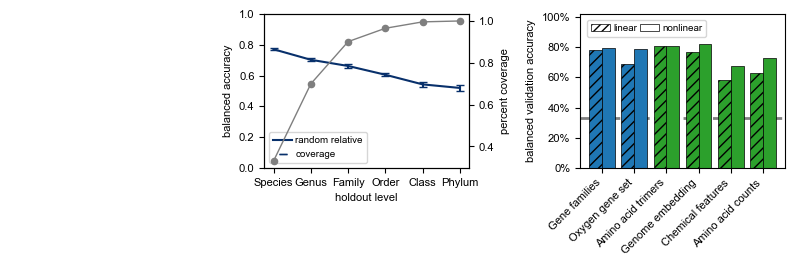

In [36]:
fig = plt.figure(figsize=(10, 2))
grid = GridSpec(1, 3, wspace=0.6, width_ratios=[0.7, 1, 1]) 

plot_figure_1a(grid=grid[0, 0], fig=fig)
plot_figure_1b(randrel_results, taxonomy_coverage_df, grid=grid[0, 1], fig=fig)
plot_figure_1c(nonlinear_results, logistic_results, grid=grid[0, 2], fig=fig)


plt.tight_layout()
plt.show()

# TODO
# Add a coverage line in the background of the phylogenetic CV figure. 
# In the "power of phylogeny" panel, only show the meanrel results with the coverage line. Leave the other stuff in the SI figure. 
